<a href="https://colab.research.google.com/github/adenikeadewumi/ML-Projects/blob/main/Mnist_handwritten_digit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importations

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

Load dataset

In [ ]:
# Define transform: normalize, flatten
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: torch.flatten(x))
])
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# With transform
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)




100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.31MB/s]


In [ ]:
# Without full transform (just ToTensor)
training_data1 = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform1,
)
test_data1 = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform1,
)

In [ ]:
#Create dataloaders
trainloader_tranformed = DataLoader(training_data, batch_size=64, shuffle=True)
testloader_transformed = DataLoader(test_data, batch_size=64, shuffle=True)

trainloader= DataLoader(training_data1, batch_size=64, shuffle=True)
testloader= DataLoader(test_data1, batch_size=64, shuffle=True)



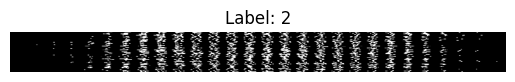

In [ ]:
import matplotlib.pyplot as plt


# Fetch one batch
images, labels = next(iter(trainloader_tranformed))

# Reverse normalization and flattening for just the first image
#img = images[0] * 0.3081 + 0.1307  # Unnormalize
#img = img.view(28, 28)            # Unflatten

plt.imshow(images, cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()


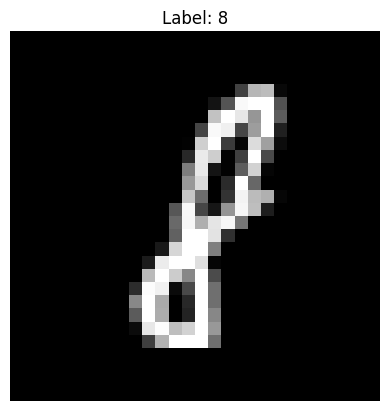

In [ ]:
#Visualize inverted normalized image
# Fetch one batch
images, labels = next(iter(trainloader_tranformed))

# Reverse normalization and flattening for just the first image
img = images[0] * 0.3081 + 0.1307  # Unnormalize
img = img.view(28, 28)      # Unflatten

plt.imshow(img, cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()


In [ ]:
images[0].shape

torch.Size([784])

In [ ]:
img.shape

torch.Size([28, 28])

Build Neural network

In [ ]:
#Build Conv2d model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1= nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2= nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1= nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2= nn.Linear(in_features=128, out_features=10)
        self.relu= nn.ReLU()
        self.flatten= nn.Flatten()

    def forward(self, x):
        x= self.conv1(x)
        x= self.relu(x)
        x= self.pool(x)
        x= self.conv2(x)
        x= self.relu(x)
        x= self.pool(x)
        x= self.flatten(x)
        x= self.fc1(x)
        x= self.relu(x)
        x= self.fc2(x)
        return x

model= NeuralNetwork()


Training

In [ ]:
from tqdm import tqdm

In [ ]:
num_epochs=3
optimizer= torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn= nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss= 0.0
    train_correct= 0
    for inputs, targets in tqdm(trainloader):
        # Forward pass
        optimizer.zero_grad()
        outputs= model(inputs)
        loss= loss_fn(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        _, predicted= torch.max(outputs.data, 1)
        train_correct+= (predicted== targets).sum().item()
    print(f"Epoch [{epoch+1}/{num_epochs}], training_accuracy: {100*train_correct/len(trainloader.dataset):.2f}%,  training_loss: {train_loss/len(trainloader):.4f}")

    val_loss= 0.0
    val_correct= 0
    val_total= 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            outputs= model(inputs)
            loss= loss_fn(outputs, targets)
            val_loss+= loss.item()
            _, predicted= torch.max(outputs.data, 1)
            val_correct+= (predicted== targets).sum().item()
            val_total += targets.size(0)
        print(f"Epoch [{epoch+1}/{num_epochs}], validation_accuracy: {100*val_correct/len(testloader.dataset):.2f}%,  validation_loss: {val_loss/len(testloader):.4f}")




100%|██████████| 938/938 [01:15<00:00, 12.41it/s]


Epoch [1/3], training_accuracy: 99.31%,  training_loss: 0.0235
Epoch [1/3], validation_accuracy: 99.01%,  validation_loss: 0.0385


100%|██████████| 938/938 [01:13<00:00, 12.74it/s]


Epoch [2/3], training_accuracy: 99.65%,  training_loss: 0.0114
Epoch [2/3], validation_accuracy: 98.94%,  validation_loss: 0.0392


100%|██████████| 938/938 [01:13<00:00, 12.72it/s]


Epoch [3/3], training_accuracy: 99.80%,  training_loss: 0.0072
Epoch [3/3], validation_accuracy: 99.13%,  validation_loss: 0.0398


In [ ]:
test_accuracy = 100 * val_correct / val_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 99.13%


Tune Model

In [ ]:
torch.save(model.state_dict(), 'model1.pth')

Fully Connected architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten= nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)
        return x
model1= FullyConnectedNN()

Training

In [ ]:
optimizer1= torch.optim.Adam(model1.parameters(), lr=0.001)
loss_fn= nn.CrossEntropyLoss()

In [ ]:
EPOCHS= 7
for epoch in range(EPOCHS):
    model1.train()
    train_loss= 0.0
    train_correct= 0
    for inputs, targets in tqdm(trainloader):
        # Forward pass
        optimizer1.zero_grad()
        outputs= model1(inputs)
        loss= loss_fn(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer1.step()

        train_loss+= loss.item()
        _, predicted= torch.max(outputs.data, 1)
        train_correct+= (predicted== targets).sum().item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], training_accuracy: {100*train_correct/len(trainloader.dataset):.2f}%,  training_loss: {train_loss/len(trainloader):.4f}")

    val_loss= 0.0
    val_correct= 0
    val_total= 0
    model1.eval()
    with torch.no_grad():
        for inputs, targets in testloader:
            outputs= model1(inputs)
            loss= loss_fn(outputs, targets)
            val_loss+= loss.item()
            _, predicted= torch.max(outputs.data, 1)
            val_correct+= (predicted== targets).sum().item()
            val_total += targets.size(0)
        print(f"Epoch [{epoch+1}/{EPOCHS}], validation_accuracy: {100*val_correct/len(testloader.dataset):.2f}%,  validation_loss: {val_loss/len(testloader):.4f}")


100%|██████████| 938/938 [00:18<00:00, 51.30it/s]


Epoch [1/7], training_accuracy: 98.40%,  training_loss: 0.0488
Epoch [1/7], validation_accuracy: 97.82%,  validation_loss: 0.0737


100%|██████████| 938/938 [00:17<00:00, 53.92it/s]


Epoch [2/7], training_accuracy: 98.49%,  training_loss: 0.0472
Epoch [2/7], validation_accuracy: 98.18%,  validation_loss: 0.0675


100%|██████████| 938/938 [00:17<00:00, 55.09it/s]


Epoch [3/7], training_accuracy: 98.60%,  training_loss: 0.0443
Epoch [3/7], validation_accuracy: 98.14%,  validation_loss: 0.0688


100%|██████████| 938/938 [00:18<00:00, 51.99it/s]


Epoch [4/7], training_accuracy: 98.70%,  training_loss: 0.0415
Epoch [4/7], validation_accuracy: 98.03%,  validation_loss: 0.0709


100%|██████████| 938/938 [00:25<00:00, 36.15it/s]


Epoch [5/7], training_accuracy: 98.67%,  training_loss: 0.0415
Epoch [5/7], validation_accuracy: 98.29%,  validation_loss: 0.0637


100%|██████████| 938/938 [00:16<00:00, 55.59it/s]


Epoch [6/7], training_accuracy: 98.78%,  training_loss: 0.0389
Epoch [6/7], validation_accuracy: 98.05%,  validation_loss: 0.0809


100%|██████████| 938/938 [00:27<00:00, 34.66it/s]


Epoch [7/7], training_accuracy: 98.70%,  training_loss: 0.0401
Epoch [7/7], validation_accuracy: 98.30%,  validation_loss: 0.0654


In [ ]:
test_accuracy2 = 100 * val_correct / val_total
print(f"Final Test Accuracy: {test_accuracy2:.2f}%")

Final Test Accuracy: 98.30%


Confusion Matrix for Conv2d model

In [ ]:
torch.save(model1.state_dict(), 'model2.pth')

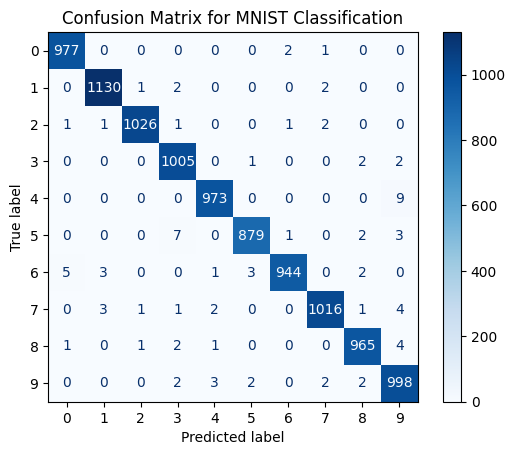

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Put model in evaluation mode
model.eval()

# Store all predictions and targets
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST Classification")
plt.show()


Confusion Matrix for FCC model

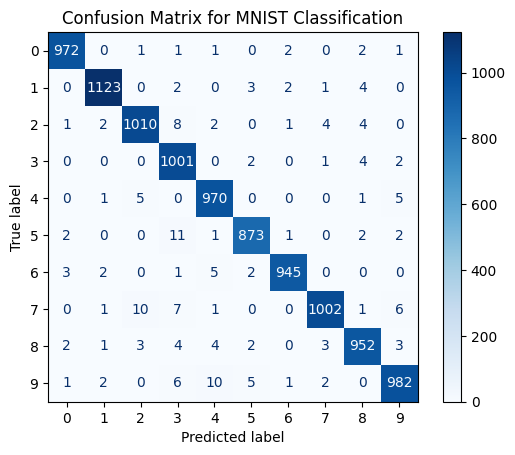

In [ ]:

# Put model in evaluation mode
model.eval()

# Store all predictions and targets
all_preds1 = []
all_labels1 = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model1(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds1.extend(predicted.cpu().numpy())
        all_labels1.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels1, all_preds1)

# Plot the confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp1.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST Classification")
plt.show()
